# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.


Первое, что предстоит сделать-это обработать данные: создадим формулу вычисления эффективности обогащения, сравним и проанализируем датасеты, рассмотрим пропуски, выбросы в данных. Далее проанализируем данные: рассмотрим изменение концентраций элементов на всех этапах, распределение размера гранул, а также суммарные концентрации элементов. На завершающем этапе создадим модель: создадим функцию вычисления sMAPE, рассмотрим три модели, выберем лучшую и проверим её качество.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import  make_pipeline
from sklearn.impute import KNNImputer

import warnings
warnings.filterwarnings("ignore")

In [2]:
try:
    data_train = pd.read_csv('C:/Users/klimatutti/Downloads/gold_recovery_train_new.csv', index_col='date')
    data_test = pd.read_csv('C:/Users/klimatutti/Downloads/gold_recovery_test_new.csv', index_col='date')
    data_full = pd.read_csv('C:/Users/klimatutti/Downloads/gold_recovery_full_new.csv', index_col='date')
except:
    data_train = pd.read_csv('/datasets/gold_recovery_train_new.csv', index_col='date')
    data_test = pd.read_csv('/datasets/gold_recovery_test_new.csv', index_col='date')
    data_full = pd.read_csv('/datasets/gold_recovery_full_new.csv', index_col='date')

**Рассмотрим общую информацию о данных**

In [3]:
def info(data):
    print('Размер данных:', data.shape)
    print('Общая информация о данных:', data.info())
    print('Количество пропусков:', data.isna().sum())
    print('Количество дубликатов:', data.duplicated().sum())

In [4]:
info(data_train)

Размер данных: (14149, 86)
<class 'pandas.core.frame.DataFrame'>
Index: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14148 non-null  float64
 1   final.output.concentrate_pb                         14148 non-null  float64
 2   final.output.concentrate_sol                        13938 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14049 non-null  float64
 7   final.output.tail_sol                               14144 non-null  float64
 8   final.output.tail_au  

Очень многоо данных и в большинстве есть пропуски. Дубликатов не обнаружено.

**Пропуски придется чем-то заполнять, поэтому рассмотрим корреляцию между признаками**

In [5]:
data_train.corr()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
final.output.concentrate_ag,1.000000,0.021110,0.351985,-0.104934,0.133238,0.289552,-0.099818,0.045896,0.193935,0.015923,...,0.041765,0.169538,0.020832,0.005319,0.013019,0.228753,0.021660,0.199048,0.170298,0.061009
final.output.concentrate_pb,0.021110,1.000000,-0.008451,0.320916,0.095000,-0.100616,0.240650,0.068287,0.029186,0.124170,...,-0.001365,-0.035219,0.092632,0.069315,0.095147,-0.096191,0.123765,-0.115190,-0.018740,0.075302
final.output.concentrate_sol,0.351985,-0.008451,1.000000,0.217363,0.249632,0.225460,0.259185,-0.023407,0.244294,0.343058,...,-0.007337,0.268279,0.032091,0.134591,0.031137,0.246817,0.015942,0.234651,0.228520,-0.276807
final.output.concentrate_au,-0.104934,0.320916,0.217363,1.000000,0.253067,0.079619,0.067949,0.098396,-0.070600,0.108014,...,0.035814,-0.042100,0.002307,-0.011165,0.005808,-0.098015,-0.014616,-0.086371,-0.123644,-0.030628
final.output.recovery,0.133238,0.095000,0.249632,0.253067,1.000000,0.151610,-0.151287,-0.088242,-0.435553,0.398307,...,0.207745,0.057454,0.170838,-0.088934,0.098267,0.024196,0.068331,0.043838,-0.027593,-0.035658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
secondary_cleaner.state.floatbank5_a_level,0.228753,-0.096191,0.246817,-0.098015,0.024196,-0.008345,0.066600,-0.085835,0.116366,-0.031146,...,0.105263,0.790037,0.013033,0.554604,0.083423,1.000000,0.036557,0.884422,0.512286,0.379832
secondary_cleaner.state.floatbank5_b_air,0.021660,0.123765,0.015942,-0.014616,0.068331,0.008731,0.216899,-0.133159,-0.104743,-0.000789,...,0.723039,0.244762,0.878027,0.153923,0.892482,0.036557,1.000000,0.046352,0.474619,-0.025908
secondary_cleaner.state.floatbank5_b_level,0.199048,-0.115190,0.234651,-0.086371,0.043838,-0.000398,0.075721,-0.104591,0.101261,-0.022692,...,0.110727,0.747276,0.035808,0.515643,0.100697,0.884422,0.046352,1.000000,0.493110,0.342094
secondary_cleaner.state.floatbank6_a_air,0.170298,-0.018740,0.228520,-0.123644,-0.027593,-0.103898,0.072273,0.001968,0.068385,-0.106076,...,0.205628,0.566670,0.311765,0.271796,0.440929,0.512286,0.474619,0.493110,1.000000,0.098643


Есть несколько признаков, между которыми корреляция составляет 0.8

**Остальные датасеты рассмотрим таким же путем**

In [6]:
info(data_test)

Размер данных: (5290, 52)
<class 'pandas.core.frame.DataFrame'>
Index: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5286 non-null   float64
 1   primary_cleaner.input.depressant            5285 non-null   float64
 2   primary_cleaner.input.feed_size             5290 non-null   float64
 3   primary_cleaner.input.xanthate              5286 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 9   primary_cleaner.state.floatbank

In [7]:
data_test.corr()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
primary_cleaner.input.sulfate,1.000000,0.455718,0.114456,0.497568,0.102653,0.048032,0.075737,0.138949,0.024710,0.027697,...,0.305793,0.117976,0.348395,0.068693,0.093608,0.132193,0.156583,0.072618,-0.134499,0.033945
primary_cleaner.input.depressant,0.455718,1.000000,0.215703,0.150760,0.144443,0.242592,0.148658,0.201499,0.036655,0.207632,...,0.326090,0.117510,0.238618,-0.085583,-0.090184,0.009138,0.064209,0.002988,-0.198422,0.034654
primary_cleaner.input.feed_size,0.114456,0.215703,1.000000,-0.291792,-0.064628,0.082869,-0.063490,0.071470,-0.091542,0.066384,...,-0.148328,-0.121148,-0.173658,-0.137180,-0.192880,-0.059167,-0.214970,-0.054173,0.026930,-0.083021
primary_cleaner.input.xanthate,0.497568,0.150760,-0.291792,1.000000,0.209017,-0.059553,0.153527,0.016144,0.044194,-0.078742,...,0.313377,0.131178,0.360961,0.121575,0.059162,0.128636,0.077380,0.095508,-0.218155,0.080662
primary_cleaner.state.floatbank8_a_air,0.102653,0.144443,-0.064628,0.209017,1.000000,0.121274,0.968679,-0.018713,0.814992,0.114058,...,0.469180,0.005962,0.476742,-0.058593,0.408050,0.271547,0.465492,0.161509,0.345231,0.172154
primary_cleaner.state.floatbank8_a_level,0.048032,0.242592,0.082869,-0.059553,0.121274,1.000000,0.101975,0.417515,-0.018378,0.784061,...,0.171716,0.096500,0.084418,-0.005819,-0.036132,0.164220,-0.012665,0.091263,-0.107710,0.076271
primary_cleaner.state.floatbank8_b_air,0.075737,0.148658,-0.063490,0.153527,0.968679,0.101975,1.000000,0.010220,0.862946,0.101127,...,0.483741,0.023801,0.487327,-0.080058,0.415343,0.260220,0.499829,0.155978,0.389594,0.187429
primary_cleaner.state.floatbank8_b_level,0.138949,0.201499,0.071470,0.016144,-0.018713,0.417515,0.010220,1.000000,-0.029228,0.406721,...,0.078411,0.216342,0.054902,-0.038440,-0.009671,0.029409,0.012115,0.004864,-0.006694,0.012904
primary_cleaner.state.floatbank8_c_air,0.024710,0.036655,-0.091542,0.044194,0.814992,-0.018378,0.862946,-0.029228,1.000000,0.003322,...,0.366373,0.047373,0.396029,-0.031081,0.400765,0.239333,0.500353,0.117465,0.490672,0.169634
primary_cleaner.state.floatbank8_c_level,0.027697,0.207632,0.066384,-0.078742,0.114058,0.784061,0.101127,0.406721,0.003322,1.000000,...,0.151945,0.093293,0.071559,-0.013814,-0.018878,0.143313,-0.004169,0.061153,-0.087866,0.067955


In [8]:
info(data_full)

Размер данных: (19439, 86)
<class 'pandas.core.frame.DataFrame'>
Index: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         19438 non-null  float64
 1   final.output.concentrate_pb                         19438 non-null  float64
 2   final.output.concentrate_sol                        19228 non-null  float64
 3   final.output.concentrate_au                         19439 non-null  float64
 4   final.output.recovery                               19439 non-null  float64
 5   final.output.tail_ag                                19438 non-null  float64
 6   final.output.tail_pb                                19338 non-null  float64
 7   final.output.tail_sol                               19433 non-null  float64
 8   final.output.tail_au  

In [9]:
data_full.corr()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
final.output.concentrate_ag,1.000000,0.063570,0.380142,-0.038373,0.185952,0.334596,-0.051855,0.028890,0.206569,0.071158,...,0.027343,0.104118,0.029887,-0.063246,-0.004246,0.184332,0.003693,0.156471,0.162591,0.059581
final.output.concentrate_pb,0.063570,1.000000,-0.048586,0.374400,0.151987,-0.126886,0.221372,0.094385,-0.047446,0.079160,...,0.058380,0.028962,0.115404,0.093859,0.125920,-0.024668,0.149266,-0.060038,-0.042372,0.067458
final.output.concentrate_sol,0.380142,-0.048586,1.000000,0.261225,0.265993,0.286305,0.221714,-0.023865,0.267781,0.316233,...,-0.049341,0.147304,0.020544,0.002077,-0.002361,0.163992,-0.009510,0.152343,0.245158,-0.216734
final.output.concentrate_au,-0.038373,0.374400,0.261225,1.000000,0.288568,0.080381,0.081291,0.134978,-0.031696,0.102781,...,0.008308,-0.019481,-0.015284,-0.018636,-0.000971,-0.080786,-0.016961,-0.084962,-0.082184,-0.019523
final.output.recovery,0.185952,0.151987,0.265993,0.288568,1.000000,0.125986,-0.143094,-0.050280,-0.409200,0.366954,...,0.167059,0.031317,0.158557,-0.049973,0.067014,0.011871,0.052017,0.016480,-0.025192,-0.005305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
secondary_cleaner.state.floatbank5_a_level,0.184332,-0.024668,0.163992,-0.080786,0.011871,-0.021662,0.015060,-0.073670,0.035272,-0.098079,...,0.175689,0.737533,0.069865,0.417890,0.154722,1.000000,0.108107,0.818406,0.464142,0.344494
secondary_cleaner.state.floatbank5_b_air,0.003693,0.149266,-0.009510,-0.016961,0.052017,-0.013677,0.132744,-0.135330,-0.160522,-0.088879,...,0.734503,0.289059,0.855785,0.099747,0.895832,0.108107,1.000000,0.090751,0.491707,-0.011976
secondary_cleaner.state.floatbank5_b_level,0.156471,-0.060038,0.152343,-0.084962,0.016480,-0.003762,0.041558,-0.087635,0.063404,-0.054203,...,0.147999,0.630466,0.076251,0.364582,0.135991,0.818406,0.090751,1.000000,0.411510,0.327861
secondary_cleaner.state.floatbank6_a_air,0.162591,-0.042372,0.245158,-0.082184,-0.025192,-0.055311,0.007496,-0.070706,0.038797,-0.175804,...,0.229330,0.503967,0.311676,0.087389,0.473300,0.464142,0.491707,0.411510,1.000000,0.106270


**Во всех датафреймах есть пропуски, некоторые столбцы имеют корреляцию друг с другом, возможно, это поможет при изучении пропусков. В тестовом датасете не хватает 34 признака.**

### Проверка правильности расчета эффективности обогащения

Создадим функцию расчета эффективности обогащения и рассчитаем на обучающей выборке для признака `rougher.output.recovery`

In [10]:
def recovery(rougher_output, rougher_input, rougher_tail):
    recovery = (rougher_output * (rougher_input - rougher_tail)) \
    / (rougher_input * (rougher_output - rougher_tail)) * 100
    return recovery

In [11]:
recovery = recovery(data_train['rougher.output.concentrate_au'], data_train['rougher.input.feed_au'],
                    data_train['rougher.output.tail_au'])
recovery

date
2016-01-15 00:00:00    87.107763
2016-01-15 01:00:00    86.843261
2016-01-15 02:00:00    86.842308
2016-01-15 03:00:00    87.226430
2016-01-15 04:00:00    86.688794
                         ...    
2018-08-18 06:59:59    89.574376
2018-08-18 07:59:59    87.724007
2018-08-18 08:59:59    88.890579
2018-08-18 09:59:59    89.858126
2018-08-18 10:59:59    89.514960
Length: 14149, dtype: float64

Рассчитаем значение средней абсолютной ошибки между расчетами и значением признака `rougher.output.recovery`

In [12]:
mae = mean_absolute_error(data_train['rougher.output.recovery'], recovery)
print('Средняя абсолютная ошибка между расчётами и значением признака rougher.output.recovery:', mae)

Средняя абсолютная ошибка между расчётами и значением признака rougher.output.recovery: 9.73512347450521e-15


Ошибка крайне мала. Это говорит о том, что эффективность в обучающей выборке верна.

**Рассмотрим, каких данных нет в тестовой выборке**

In [13]:
test_columns = set(data_train.columns) - set(data_test.columns)
data_train[test_columns].info()

<class 'pandas.core.frame.DataFrame'>
Index: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 34 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_sol                        13938 non-null  float64
 1   primary_cleaner.output.tail_sol                     14103 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   secondary_cleaner.output.tail_ag                    14147 non-null  float64
 4   rougher.output.tail_ag                              14148 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.concentrate_au                         14149 non-null  float64
 7   rougher.output.concentrate_au                       14149 non-null  float64
 8   rougher.output.tail_au                           

В тестовой выборке нет 34 признаков. 30 из них - `output` (параметры продукта) и 4 - `calculation` (расчётные характеристики).

**Начнем предобработку данных**

Добавим в тестовую выборку недостающие признаки из полной выборки. Свяжем их по дате.

In [14]:
data_test = data_test.merge(data_full[['final.output.recovery', 'rougher.output.recovery']], on='date', how='left')
data_test.shape

(5290, 54)

Пропуски в обучающей и тестовой выборках заменим с помощью метода ближайших соседей.

In [15]:
imputer_train = KNNImputer()
data_train = pd.DataFrame(data = imputer_train.fit_transform(data_train),
             columns= data_train.columns,
             index = data_train.index)
data_train.isna().values.any()

False

In [16]:
imputer_test = KNNImputer()
data_test = pd.DataFrame(data = imputer_test.fit_transform(data_test),
             columns= data_test.columns,
             index = data_test.index)
data_test.isna().values.any()

False

От пропусков избавились

### Анализ данных

Рассмотрим изменение концентрации металлов (Au, Ag, Pb) на различных этапах очистки.

Выберем из полной выборки данные по каждому из металлов.

In [17]:
concentrate_ag = data_full[['rougher.input.feed_ag',
                       'rougher.output.concentrate_ag',
                       'primary_cleaner.output.concentrate_ag',
                       'final.output.concentrate_ag'
                      ]].mean(axis=0)
concentrate_ag

rougher.input.feed_ag                     8.794927
rougher.output.concentrate_ag            11.994759
primary_cleaner.output.concentrate_ag     8.442408
final.output.concentrate_ag               5.168470
dtype: float64

In [18]:
concentrate_pb = data_full[['rougher.input.feed_pb',
                       'rougher.output.concentrate_pb',
                      'primary_cleaner.output.concentrate_pb',
                       'final.output.concentrate_pb'
                      ]].mean(axis=0)
concentrate_pb

rougher.input.feed_pb                    3.598085
rougher.output.concentrate_pb            7.606272
primary_cleaner.output.concentrate_pb    9.829530
final.output.concentrate_pb              9.978895
dtype: float64

In [19]:
concentrate_au = data_full[['rougher.input.feed_au',
                       'rougher.output.concentrate_au',
                      'primary_cleaner.output.concentrate_au',
                       'final.output.concentrate_au'
                      ]].mean(axis=0)
concentrate_au

rougher.input.feed_au                     8.266097
rougher.output.concentrate_au            19.772000
primary_cleaner.output.concentrate_au    32.119400
final.output.concentrate_au              44.076513
dtype: float64

Построим график

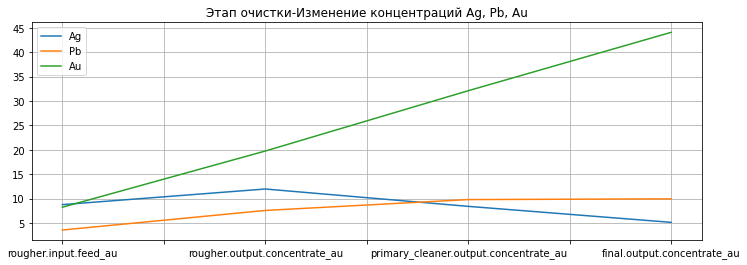

In [20]:
concentrate_ag.plot(grid=True, figsize=(12,4), label='Ag') 

concentrate_pb.plot(grid=True, figsize=(12,4), label='Pb')

concentrate_au.plot(grid=True, figsize=(12,4), label='Au')

plt.title('Этап очистки-Изменение концентраций Ag, Pb, Au')
plt.legend()
plt.show()

Концентрации Au и Pb растут: Au растет стремительно, Pb медленно. Но вот концентрация Ag после этапа флотации начинает снижаться.

### Сравним распределение гранул 

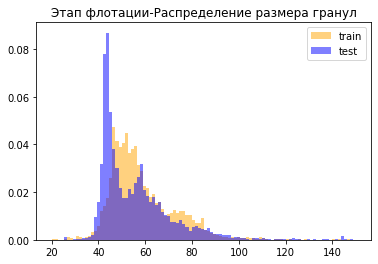

In [21]:
tr = data_train['rougher.input.feed_size']
te = data_test['rougher.input.feed_size']

plt.hist(tr, bins=100, color='orange', label='train', range=(20, 150), alpha=0.5, density=True)
plt.hist(te, bins=100, color='blue', label='test', range=(20, 150), alpha=0.5, density=True)
plt.rcParams['figure.figsize'] = (20, 5)
plt.legend(loc='upper right')
plt.title('Этап флотации-Распределение размера гранул')
plt.show()

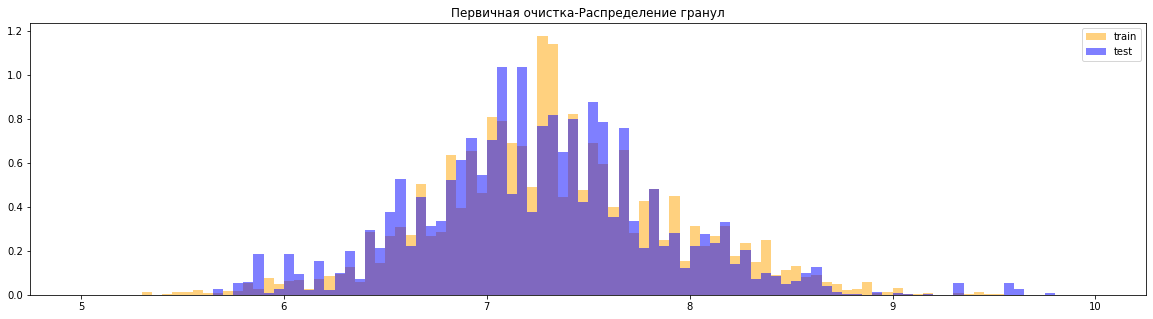

In [22]:
tr = data_train['primary_cleaner.input.feed_size']
te = data_test['primary_cleaner.input.feed_size']

plt.hist(tr, bins=100, color='orange', label='train', range=(5, 10), alpha=0.5, density=True)
plt.hist(te, bins=100, color='blue', label='test', range=(5, 10), alpha=0.5, density=True)
plt.rcParams['figure.figsize'] = (25, 5)
plt.legend(loc='upper right')
plt.title('Первичная очистка-Распределение гранул')
plt.show()

Распределения на обоих этапах между тестовой и обучающей выборками очень похожи.

**Рассмотрим суммарные концентрации веществ**

Построим табличку суммарных концентраций веществ на всех стадиях

In [23]:
sum_concentrate = pd.DataFrame()

sum_concentrate['rougher.input'] = data_full['rougher.input.feed_ag'] \
+ data_full['rougher.input.feed_pb'] \
+ data_full['rougher.input.feed_sol'] \
+ data_full['rougher.input.feed_au']

sum_concentrate['rougher.output'] = data_full['rougher.output.concentrate_ag'] \
+ data_full['rougher.output.concentrate_pb'] \
+ data_full['rougher.output.concentrate_sol'] \
+ data_full['rougher.output.concentrate_au']

sum_concentrate['primary_cleaner.output'] = data_full['primary_cleaner.output.concentrate_ag'] \
+ data_full['primary_cleaner.output.concentrate_pb'] \
+ data_full['primary_cleaner.output.concentrate_sol'] \
+ data_full['primary_cleaner.output.concentrate_au']

sum_concentrate['final.output'] = data_full['final.output.concentrate_ag'] \
+ data_full['final.output.concentrate_pb'] \
+ data_full['final.output.concentrate_sol'] \
+ data_full['final.output.concentrate_au']

sum_concentrate.describe()

,rougher.input,rougher.output,primary_cleaner.output,final.output
count,19245.000000,19416.000000,19069.000000,19227.000000
mean,57.407926,68.188914,60.949928,68.727562
std,7.165219,12.478522,9.953770,7.423741
min,0.040000,0.000000,0.000000,0.000000
25%,53.660745,66.026048,59.165854,67.985659
50%,57.647093,70.186130,62.615189,69.632597
75%,62.012223,74.362878,65.725507,71.390461
max,76.978947,88.140119,80.749343,80.210644


Посомтрим на выбросы

<AxesSubplot:>

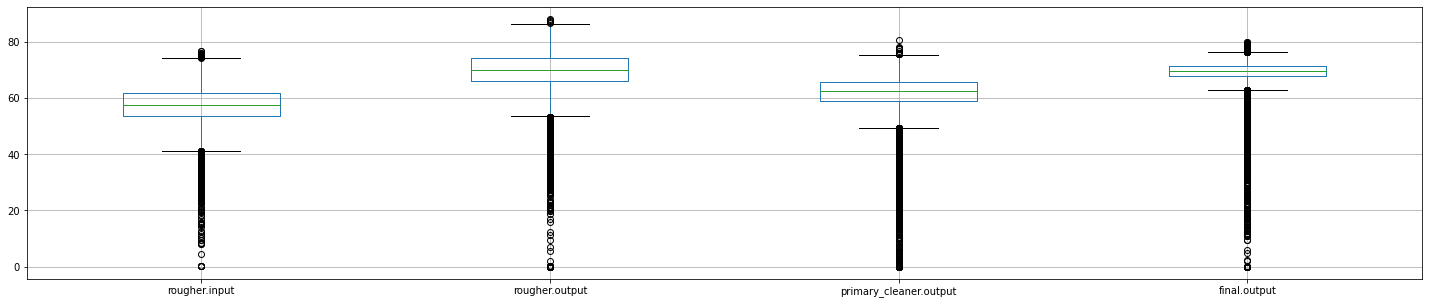

In [24]:
sum_concentrate.boxplot()

**Есть значения в нуле, они нам не нужны.**

Из всех выборок удалим концентарции меньше 1

In [25]:
data_full = data_full[(data_full['rougher.input.feed_ag'] >= 1) &
            (data_full['rougher.input.feed_pb'] >= 1) &
            (data_full['rougher.input.feed_sol'] >= 1) &
            (data_full['rougher.input.feed_au'] >= 1) &
            (data_full['rougher.output.concentrate_ag'] >= 1) &
            (data_full['rougher.output.concentrate_pb'] >= 1) &
            (data_full['rougher.output.concentrate_sol'] >= 1) &
            (data_full['rougher.output.concentrate_au'] >= 1) &
            (data_full['primary_cleaner.output.concentrate_ag'] >= 1) &
            (data_full['primary_cleaner.output.concentrate_pb'] >= 1) &
            (data_full['primary_cleaner.output.concentrate_sol'] >= 1) &
            (data_full['primary_cleaner.output.concentrate_au'] >= 1) &
            (data_full['final.output.concentrate_ag'] >= 1) &
            (data_full['final.output.concentrate_pb'] >= 1) &
            (data_full['final.output.concentrate_sol'] >= 1) &
            (data_full['final.output.concentrate_au'] >= 1)]

In [26]:
data_test = data_test[(data_test['rougher.input.feed_ag'] >= 1) &
            (data_test['rougher.input.feed_pb'] >= 1) &
            (data_test['rougher.input.feed_sol'] >= 1) &
            (data_test['rougher.input.feed_au'] >= 1)]

In [27]:
data_train = data_train[(data_train['rougher.input.feed_ag'] >= 1) &
            (data_train['rougher.input.feed_pb'] >= 1) &
            (data_train['rougher.input.feed_sol'] >= 1) &
            (data_train['rougher.input.feed_au'] >= 1) &
            (data_train['rougher.output.concentrate_ag'] >= 1) &
            (data_train['rougher.output.concentrate_pb'] >= 1) &
            (data_train['rougher.output.concentrate_sol'] >= 1) &
            (data_train['rougher.output.concentrate_au'] >= 1) &
            (data_train['primary_cleaner.output.concentrate_ag'] >= 1) &
            (data_train['primary_cleaner.output.concentrate_pb'] >= 1) &
            (data_train['primary_cleaner.output.concentrate_sol'] >= 1) &
            (data_train['primary_cleaner.output.concentrate_au'] >= 1) &
            (data_train['final.output.concentrate_ag'] >= 1) &
            (data_train['final.output.concentrate_pb'] >= 1) &
            (data_train['final.output.concentrate_sol'] >= 1) &
            (data_train['final.output.concentrate_au'] >= 1)]

### Модель

Построим функцию расчета sMAPE и финального sMAPE

In [28]:
def sMAPE(target, predict):
    smape = np.mean(abs(target-predict) / ((abs(target) + abs(predict)) / 2)) * 100
    return smape

In [29]:
def sMAPE_fin(smape_rougher, smape_final):
    return (0.25 * smape_rougher + 0.75 * smape_final)

Разделим данные на признаки и целевые признаки

In [30]:
features_train = np.array(data_train.drop(['rougher.output.recovery', 'final.output.recovery',
                                     'rougher.output.concentrate_au', 'primary_cleaner.output.tail_pb',
                                      'final.output.concentrate_au', 'primary_cleaner.output.concentrate_pb',
                                      'final.output.tail_sol',
                                      'rougher.calculation.floatbank10_sulfate_to_au_feed',
                                      'rougher.output.tail_sol', 'final.output.tail_au',
                                      'primary_cleaner.output.concentrate_ag',
                                      'rougher.calculation.floatbank11_sulfate_to_au_feed',
                                      'rougher.output.tail_ag', 'rougher.output.tail_pb',
                                      'secondary_cleaner.output.tail_pb', 'final.output.tail_ag',
                                      'final.output.concentrate_sol', 'primary_cleaner.output.tail_au',
                                      'secondary_cleaner.output.tail_sol', 'secondary_cleaner.output.tail_ag',
                                      'rougher.output.tail_au', 'rougher.output.concentrate_ag',
                                      'primary_cleaner.output.concentrate_sol', 'final.output.concentrate_pb',
                                      'final.output.concentrate_ag', 'secondary_cleaner.output.tail_au',
                                      'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
                                      'primary_cleaner.output.tail_sol',
                                      'rougher.calculation.sulfate_to_au_concentrate',
                                      'final.output.tail_pb', 'primary_cleaner.output.concentrate_au',
                                      'primary_cleaner.output.tail_ag', 'rougher.calculation.au_pb_ratio'], 
                                     axis=1))

target_train_rougher = np.array(data_train['rougher.output.recovery'])
target_train_final = np.array(data_train['final.output.recovery'])

for sample in [features_train, target_train_rougher, target_train_final]:
    print(sample.shape)

(13425, 52)
(13425,)
(13425,)


Для финальной проверки (кросс-валидации) создадим собственную метрику score

In [31]:
score = make_scorer(sMAPE, greater_is_better = False) 

Используем три модели: Случайный лес, Дерево решений и Линейная регрессия. Используем pipline для оптимизации, в него передаем модель и метод стандартизации данных.

In [32]:
model_rfr = make_pipeline(StandardScaler(), RandomForestRegressor())

model_dtr = make_pipeline(StandardScaler(), DecisionTreeRegressor())

model_lr = make_pipeline(StandardScaler(), LinearRegression())

Для каждой модели прописываем параметры

In [33]:
model_rfr_param = {'randomforestregressor__n_estimators':[1,100],
                  'randomforestregressor__max_depth':[1,10],
                  'randomforestregressor__random_state':[12345]}

model_dtr_param = {'decisiontreeregressor__max_depth':[1,10],
                 'decisiontreeregressor__random_state':[12345]}

model_lr_param = {'linearregression__normalize':[False]}

Для перебора параметров используем инструмент GridSearchCV

In [34]:
grid_rougher_rfr = GridSearchCV(model_rfr, param_grid=model_rfr_param, cv=5, scoring=score)
grid_final_rfr = GridSearchCV(model_rfr, param_grid=model_rfr_param, cv=5, scoring=score)

grid_rougher_dtr = GridSearchCV(model_dtr, param_grid=model_dtr_param, cv=5, scoring=score)
grid_final_dtr = GridSearchCV(model_dtr, param_grid=model_dtr_param, cv=5, scoring=score)

grid_rougher_lr = GridSearchCV(model_lr, param_grid=model_lr_param, scoring=score)
grid_final_lr = GridSearchCV(model_lr, param_grid=model_lr_param, scoring=score)

Обучаем модели

In [35]:
grid_rougher_rfr.fit(features_train, target_train_rougher)
grid_final_rfr.fit(features_train, target_train_final)

grid_rougher_dtr.fit(features_train, target_train_rougher)
grid_final_dtr.fit(features_train, target_train_final)

grid_rougher_lr.fit(features_train, target_train_rougher)
grid_final_lr.fit(features_train, target_train_final)

GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'linearregression__normalize': [False]},
             scoring=make_scorer(sMAPE, greater_is_better=False))

Применим для двух целевых признаков и сравним модели

In [36]:
best_score_rougher_rfr = grid_rougher_rfr.best_score_
best_score_final_rfr = grid_final_rfr.best_score_

best_score_rougher_dtr = grid_rougher_dtr.best_score_
best_score_final_dtr = grid_final_dtr.best_score_

best_score_rougher_lr = grid_rougher_lr.best_score_
best_score_final_lr = grid_final_lr.best_score_

print('Случайный лес лучший rougher', best_score_rougher_rfr)
print('Дерево решений лучший rougher', best_score_rougher_dtr)
print('Линейная регрессия лучший rougher', best_score_rougher_lr)
print('Случайный лес лучший final', best_score_final_rfr)
print('Дерево решений лучший final', best_score_final_dtr)
print('Линейная регрессия лучший final', best_score_final_lr)

Случайный лес лучший rougher -6.493869061140179
Дерево решений лучший rougher -7.962795330896439
Линейная регрессия лучший rougher -7.1215484931955135
Случайный лес лучший final -9.253971010146081
Дерево решений лучший final -9.502834455132593
Линейная регрессия лучший final -10.90484305294757


Рассчитаем значение sMAPE для всех моделей

In [37]:
final_smape_rfr = sMAPE_fin(best_score_rougher_rfr, best_score_final_rfr)
print('Случайный лес sMAPE', final_smape_rfr)

final_smape_dtr = sMAPE_fin(best_score_rougher_dtr, best_score_final_dtr)
print('Дерево решений sMAPE', final_smape_dtr)

final_smape_lr = sMAPE_fin(best_score_rougher_lr, best_score_final_lr)
print('Линейная регрессия sMAPE', final_smape_lr)

Случайный лес sMAPE -8.563945522894606
Дерево решений sMAPE -9.117824674073555
Линейная регрессия sMAPE -9.959019413009555


**Лучшее значение показала модель Случайного леса**

Рассчитаем финальное sMAPE для тестовой выборки по модели Случайного леса

In [38]:
features_test = np.array(data_test.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1))
target_test_rouger = np.array(data_test['rougher.output.recovery'])
target_test_final = np.array(data_test['final.output.recovery'])

test_rogher = grid_rougher_rfr.predict(features_test) 
test_final = grid_final_rfr.predict(features_test)

rouger_smape_test = sMAPE(target_test_rouger, test_rogher)
final_smape_test = sMAPE(target_test_final, test_final)

final_smape = sMAPE_fin(rouger_smape_test, final_smape_test)
print('sMAPE на тестовой выборке =', round(final_smape,3))

sMAPE на тестовой выборке = 8.887


**Проверим модель на вменяемость**

In [39]:
for i in ['mean', 'median']:
    dummy_rougher = DummyRegressor(strategy=i)
    dummy_final = DummyRegressor(strategy=i)
    
    dummy_rougher.fit(features_train, target_train_rougher)
    dummy_final.fit(features_train, target_train_final)
    
    rougher = dummy_rougher.predict(data_test)
    final = dummy_final.predict(data_test)
    
    final_smape = sMAPE_fin(sMAPE(target_test_rouger, rougher),
                                   sMAPE(target_test_final, final))

    print('Для стратегии', i, 'итоговая sMAPE =', round(final_smape,3))

Для стратегии mean итоговая sMAPE = 9.68
Для стратегии median итоговая sMAPE = 9.322


**Значение модели Случайного леса оказались выше константной модели, поэтому модель вменяема**

## Вывод

В данном проекте перед нами стояла задача предсказать коэффициент восстановления золота из золотосодержащей руды.

Первое, что было сделано: подготовлены данные

Мы рассмотрели общую информацию о датасетах, увидели различия между ними, избавились от пропусков значений, а также от пропусков признаков в тестовой выборке. Проверили формулу вычисления эффективности обогащения, в данных эффективность оказалась верной.

Затем проводился анализ данных

Мы рассмотрели изменение концентраций элементов на всех этапах, распределения размеров гранул - увидели, что они очень схожи, а также проанализировали суммарные концентрации - избавились от выбросов в нулевом значении.

На третьем этапе создавалась модель

Написана функция для вычисления sMAPE, применено три разных модели, подобраны параметры. Лучшей моделью оказалась модель Случайного леса **sMAPE = -8.563945522894606**. И в заключении модель была проверена на вменяемость.